# Difference-in-differences (DiD)

**Treatment period:**
\begin{equation}
Y_{t} = \beta_0 + \beta_1 D_t + \varepsilon_{t}
\end{equation}

$Y_{t}$ is the price for observation $i$ in time period $t$, 
$D_i$ is a dummy variable that takes the value of 1 during the treatment period and 0 otherwise, and 
$\beta_1$ captures the average treatment effect over time

**Treatment city:**
\begin{equation}
Y_{i} = \beta_0 + \beta_2 T_i + \varepsilon_{i}
\end{equation}

$T_i$ is a dummy variable that takes the value of 1 for the treatment city and 0 otherwise, 
$\beta_2$ captures the average difference in prices between the treatment city and the control cities

**Both (final equation):**
\begin{equation}
Y_{it} = \beta_0 + \beta_1 D_t + \beta_2 T_i + \alpha D_t T_i + \varepsilon_{it}
\end{equation}

$T_i$ is the treatment period dummy,
$D_i$ is the treatment city, 
$\alpha$ is the one that captures the DiD estimate, which is the differential change in prices for the treatment group compared to the control group, and
where $T_i = 1$ if individual $i$ is treatment period $t=1$ and $T_i=0$ otherwise


**Why use a second city**

The second city plays the role of a control group which is crucial for DiD analysis because it helps control for time-invariant unobserved factors that may affect prices in both the treatment and control groups. The key assumption in a DiD analysis is the parallel trends assumption, which implies that, in the absence of the treatment, the average outcomes for the treatment and control groups would follow parallel paths over time. Violation of this assumption could lead to biased estimates.


**Why $\alpha$ captures the treatment effect:**

If $\alpha$ is statistically significant and positive, it suggests that the treatment (event) had a differential impact on prices in the treatment city compared to the control cities. This coefficient captures the average treatment effect on prices that cannot be explained by time trends or differences between the treatment and control cities.



In [28]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.api as smf
import numpy as np

In [29]:
def openbarcelona(path):
    ''' Function to open 2 dataframes:
    - df1 which is the df of Barcelona the week of the event 
    - df2 which is the df of Barcelona another random no-event week
    '''
    df1 = pd.read_csv(path + '/barcelona_p1.csv')
    df2 = pd.read_csv(path + '/barcelona_p2.csv')
    return df1, df2

In [30]:
df1, df2 = openbarcelona('C:/Users/arimi/Documents/BSE-term2/text-mining/Booking-Scraping/data')

In [31]:
def choosecity(path, city):
    ''' Function to open 2 dataframes:
    - df1 which is the df of the choosen city the week of the event 
    - df2 which is the df of the choosen city another random no-event week
    '''
    df3 = pd.read_csv(path + city + '_p1.csv')
    df4 = pd.read_csv(path + city + '_p2.csv')
    return df3, df4

In [32]:
#Put the city all in low case
df3, df4 = choosecity('C:/Users/arimi/Documents/BSE-term2/text-mining/Booking-Scraping/data/', 'marseille') 

In [33]:
# Eliminate the euro sign from the price feature and then transforming from object to numeric
df1['price'] = pd.to_numeric(df1['price'].replace('[^\d]', '', regex=True))
df2['price'] = pd.to_numeric(df2['price'].replace('[^\d]', '', regex=True))
df3['price'] = pd.to_numeric(df3['price'].replace('[^\d]', '', regex=True))
df4['price'] = pd.to_numeric(df4['price'].replace('[^\d]', '', regex=True))

In [34]:
df1.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description
0,0,Barcelona,2024-02-23,2024-03-03,Duquesa Suites Barcelona,3491,NaN,8.8,https://www.booking.com/hotel/es/duquesa-suite...,"Set the centre of Barcelona, 400 metres from P..."
1,1,Barcelona,2024-02-23,2024-03-03,Sonder Casa Luz,4457,NaN,8.4,https://www.booking.com/hotel/es/casa-luz-barc...,"Set in Barcelona, Sonder Casa Luz offers a ter..."
2,2,Barcelona,2024-02-23,2024-03-03,Valencia 2,1395,NaN,NaN,https://www.booking.com/hotel/es/valencia-2.en...,"Located in Barcelona, 1.2 km from Passeig de G..."
3,3,Barcelona,2024-02-23,2024-03-03,Fuster Apartments by Aspasios,2448,Entire apartment • 2 bedrooms • 1 living room ...,9.2,https://www.booking.com/hotel/es/fuster-apartm...,Fuster Apartments are just 150 metres from Dia...
4,4,Barcelona,2024-02-23,2024-03-03,BarcelonaForRent The Central Place,5350,Entire apartment • 1 bedroom • 1 living room •...,8.5,https://www.booking.com/hotel/es/barcelonaforr...,"Offering views of Casa Batlló, BarcelonaForRen..."


In [35]:
df1.describe()

,Unnamed: 0,price,rating
count,1001.000000,1001.000000,945.000000
mean,500.000000,3379.912088,7.852804
std,289.108111,1836.851740,1.127298
min,0.000000,601.000000,1.000000
25%,250.000000,2317.000000,7.300000
50%,500.000000,2999.000000,8.000000
75%,750.000000,3903.000000,8.500000
max,1000.000000,17158.000000,10.000000


In [36]:
df1.shape

(1001, 10)

In [37]:
df4.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description
0,0,Marseille,2024-03-08,2024-03-17,Résidence Kley,477,NaN,7.6,https://www.booking.com/hotel/fr/residence-kle...,"Résidence Kley has a shared lounge, terrace, w..."
1,1,Marseille,2024-03-08,2024-03-17,La Terrasse du Saint James,515,NaN,NaN,https://www.booking.com/hotel/fr/la-terrasse-d...,"Located in Marseille, 2.3 km from Fausse Monna..."
2,2,Marseille,2024-03-08,2024-03-17,Staycity Aparthotels Marseille Centre Vieux Port,630,Entire studio • 1 bathroom • 21m²,8.7,https://www.booking.com/hotel/fr/staycity-apar...,"Featuring free WiFi, Staycity Aparthotels Mars..."
3,3,Marseille,2024-03-08,2024-03-17,LaFrenchCasa Canebière,543,Entire apartment • 1 bedroom • 1 bathroom • 1 ...,7.3,https://www.booking.com/hotel/fr/lafrenchcasa-...,LaFrenchCasa Canebière is set in the Vieux Por...
4,4,Marseille,2024-03-08,2024-03-17,Odalys City Marseille Centre Euromed,888,Entire studio • 1 bathroom • 23m²,8.4,https://www.booking.com/hotel/fr/odalys-city-m...,"Less than 1 km from Joliette Metro Station, Od..."


In [38]:
df3.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description
0,0,Marseille,2024-02-23,2024-03-03,Le Schuman - Appart 1 ch proche Panier Vieux-Port,658,Entire apartment • 1 bedroom • 1 bathroom • 1 ...,NaN,https://www.booking.com/hotel/fr/le-schuman-ap...,"Situated in Marseille, 500 metres from Joliett..."
1,1,Marseille,2024-02-23,2024-03-03,Résidence Kley,456,NaN,7.6,https://www.booking.com/hotel/fr/residence-kle...,"Résidence Kley has a shared lounge, terrace, w..."
2,2,Marseille,2024-02-23,2024-03-03,Staycity Aparthotels Marseille Centre Vieux Port,598,Entire studio • 1 bathroom • 21m²,8.7,https://www.booking.com/hotel/fr/staycity-apar...,"Featuring free WiFi, Staycity Aparthotels Mars..."
3,3,Marseille,2024-02-23,2024-03-03,ADIRA Résid'Marseille Vieux-port,711,NaN,7.9,https://www.booking.com/hotel/fr/adira-resid-m...,"Offering free WiFi and city views, ADIRA Résid..."
4,4,Marseille,2024-02-23,2024-03-03,Odalys City Marseille Centre Euromed,878,Entire studio • 1 bathroom • 23m²,8.4,https://www.booking.com/hotel/fr/odalys-city-m...,"Less than 1 km from Joliette Metro Station, Od..."


In [39]:
#Creation of the dummy variables for the regression
# D is treatment period
# T is treatment city
df1['D'] = 1
df1['T'] = 1
df2['D'] = 0
df2['T'] = 1
df3['D'] = 1
df3['T'] = 0
df4['D'] = 0
df4['T'] = 0

In [40]:
#Removing outliers from prices to be plot better how is the data distributed. 
#But we are running the regressions with no outlier treatment
def remove_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

df32 = remove_outliers(df3, 'price')
df42 = remove_outliers(df4, 'price')
df12 = remove_outliers(df1, 'price')
df22 = remove_outliers(df2, 'price')

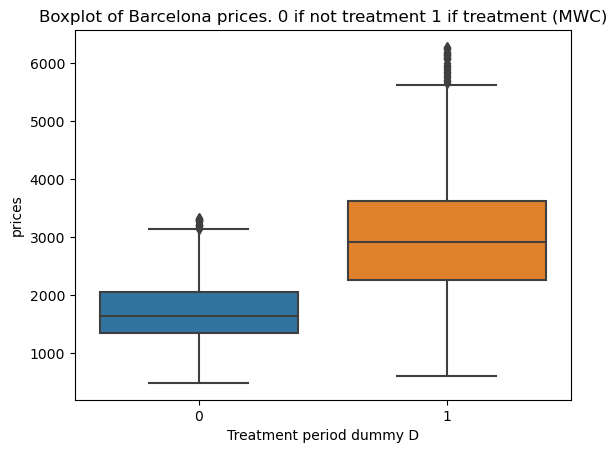

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

barcelona_df = pd.concat([df12, df22], ignore_index=True)

# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_df , x='D', y='price')
plt.title('Boxplot of Barcelona prices. 0 if not treatment 1 if treatment (MWC)')
plt.xlabel('Treatment period dummy D')
plt.ylabel('prices')
plt.show()

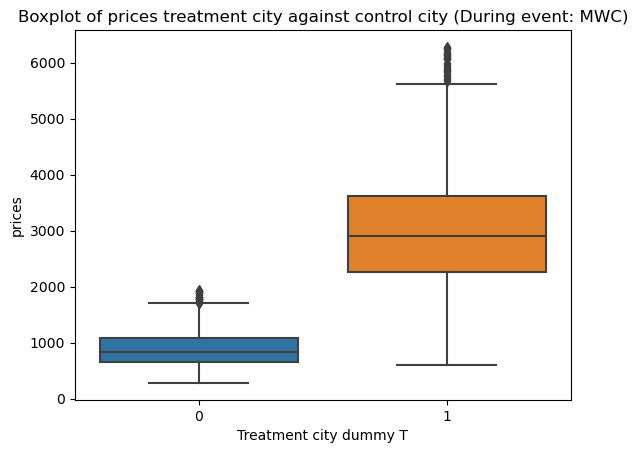

In [42]:
barcelona_city = pd.concat([df12, df32], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_city , x='T', y='price')
plt.title('Boxplot of prices treatment city against control city (During event: MWC)')
plt.xlabel('Treatment city dummy T')
plt.ylabel('prices')
plt.show()

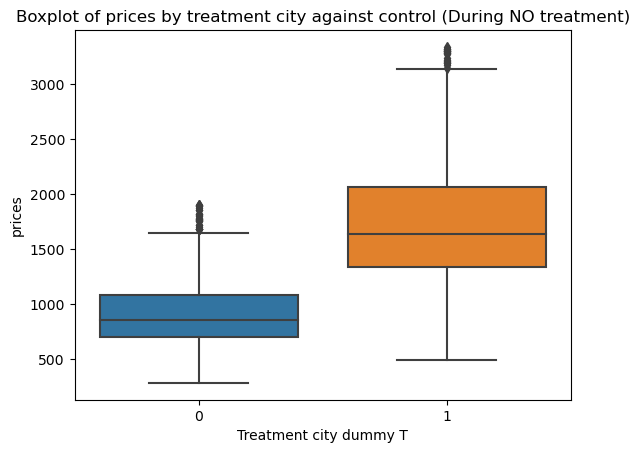

In [43]:
barcelona_cityNT = pd.concat([df22, df42], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_cityNT , x='T', y='price')
plt.title('Boxplot of prices by treatment city against control (During NO treatment)')
plt.xlabel('Treatment city dummy T')
plt.ylabel('prices')
plt.show()

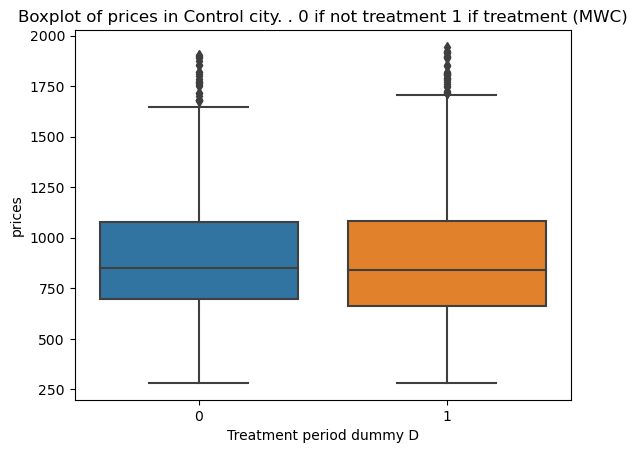

In [44]:
city = pd.concat([df32, df42], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=city , x='D', y='price')
plt.title('Boxplot of prices in Control city. . 0 if not treatment 1 if treatment (MWC)')
plt.xlabel('Treatment period dummy D')
plt.ylabel('prices')
plt.show()

In [45]:
#Creation of the big data frame
combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df['T*D'] = combined_df['T'] * combined_df['D']
# Display the combined DataFrame
combined_df.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description,D,T,T*D
0,0,Barcelona,2024-02-23,2024-03-03,Duquesa Suites Barcelona,3491,NaN,8.8,https://www.booking.com/hotel/es/duquesa-suite...,"Set the centre of Barcelona, 400 metres from P...",1,1,1
1,1,Barcelona,2024-02-23,2024-03-03,Sonder Casa Luz,4457,NaN,8.4,https://www.booking.com/hotel/es/casa-luz-barc...,"Set in Barcelona, Sonder Casa Luz offers a ter...",1,1,1
2,2,Barcelona,2024-02-23,2024-03-03,Valencia 2,1395,NaN,NaN,https://www.booking.com/hotel/es/valencia-2.en...,"Located in Barcelona, 1.2 km from Passeig de G...",1,1,1
3,3,Barcelona,2024-02-23,2024-03-03,Fuster Apartments by Aspasios,2448,Entire apartment • 2 bedrooms • 1 living room ...,9.2,https://www.booking.com/hotel/es/fuster-apartm...,Fuster Apartments are just 150 metres from Dia...,1,1,1
4,4,Barcelona,2024-02-23,2024-03-03,BarcelonaForRent The Central Place,5350,Entire apartment • 1 bedroom • 1 living room •...,8.5,https://www.booking.com/hotel/es/barcelonaforr...,"Offering views of Casa Batlló, BarcelonaForRen...",1,1,1


In [46]:
combined_df.describe() #Checked if it worked 

,Unnamed: 0,price,rating,D,T,T*D
count,4002.000000,4002.000000,3523.000000,4002.000000,4002.000000,4002.000000
mean,499.750125,1852.876062,7.963809,0.500000,0.500250,0.250125
std,288.855635,1480.138849,1.174961,0.500062,0.500062,0.433139
min,0.000000,282.000000,1.000000,0.000000,0.000000,0.000000
25%,250.000000,855.250000,7.500000,0.000000,0.000000,0.000000
50%,500.000000,1384.000000,8.100000,0.500000,1.000000,0.000000
75%,750.000000,2399.000000,8.700000,1.000000,1.000000,0.750000
max,1000.000000,17158.000000,10.000000,1.000000,1.000000,1.000000


In [47]:
#Checking before running the regressions
mean_prices = combined_df.groupby(['T', 'D']).mean()
mean_prices_table = mean_prices.reset_index()
print(mean_prices_table)

   T  D  Unnamed: 0        price    rating  T*D
0  0  0       499.5  1085.594000  7.979655  0.0
1  0  1       499.5  1073.790000  8.007239  0.0
2  1  0       500.0  1870.663337  8.023319  0.0
3  1  1       500.0  3379.912088  7.852804  1.0


C:\Users\arimi\AppData\Local\Temp\ipykernel_12576\2948570360.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_prices = combined_df.groupby(['T', 'D']).mean()


In [48]:
# Regression 1: Treatment Period Dummy Only (T)
model1 = sm.OLS(combined_df['price'], sm.add_constant(combined_df['D'])).fit()
results_summary1 = model1.params

In [49]:
model1 = sm.OLS(combined_df['price'], sm.add_constant(combined_df['D'])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     273.7
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           1.59e-59
Time:                        10:17:12   Log-Likelihood:                -34760.
No. Observations:                4002   AIC:                         6.952e+04
Df Residuals:                    4000   BIC:                         6.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1478.3248     32.015     46.175      0.0

In [50]:
# Regression 2: Treatment City Dummy Only (D)
model2 = sm.OLS(combined_df['price'], sm.add_constant(combined_df['T'])).fit()
results_summary2 = model2.params

In [51]:
model2 = sm.OLS(combined_df['price'], sm.add_constant(combined_df['T'])).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     1500.
Date:                Fri, 02 Feb 2024   Prob (F-statistic):          7.04e-279
Time:                        10:17:13   Log-Likelihood:                -34255.
No. Observations:                4002   AIC:                         6.851e+04
Df Residuals:                    4000   BIC:                         6.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1079.6920     28.230     38.247      0.0

In [52]:
# Regression 3: Both Treatment Period and City Dummy with Interaction (DiD)
all = ['D', 'T', 'T*D'] 
model3 = sm.OLS(combined_df['price'], sm.add_constant(combined_df[all])).fit()
results_summary3 = model3.params

In [53]:
model3 = sm.OLS(combined_df['price'], sm.add_constant(combined_df[all])).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     898.6
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:17:13   Log-Likelihood:                -33861.
No. Observations:                4002   AIC:                         6.773e+04
Df Residuals:                    3998   BIC:                         6.776e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1085.5940     36.187     30.000      0.0

In [54]:
# Convert to DataFrames
df1 = pd.DataFrame(results_summary1, index=['const', 'D'])
df2 = pd.DataFrame(results_summary2, index=['const', 'T'])
df3 = pd.DataFrame(results_summary3, index=['const', 'D', 'T', 'T*D'])

# Concatenate the DataFrames side by side
combined_results = pd.concat([df1, df2, df3], axis=1, keys=['Model 1', 'Model 2', 'Model 3'])

# Display the combined table
print(combined_results)

           Model 1      Model 2      Model 3
                 0            0            0
const  1478.324838  1079.692000  1085.594000
D       749.102449          NaN   -11.804000
T              NaN  1545.595712   785.069337
T*D            NaN          NaN  1521.052751


**Model 1: Treatment period**

$\beta_0$: The average price when the treatment is not in effect is 1478.32. This serves as the baseline price in periods without the treatment.

$\beta_1$: The coefficient of 749.10 for the treatment period dummy indicates that, during the treatment period, prices were on average 654.99 units higher than in periods without the treatment. This captures the average effect of the treatment over time, but without distinguishing between cities.

**Model 2: Treatment city:**

$\beta_0$: The average price in the control city is 1079.69, this could be interpretated as the baseline.

$\beta_2$: The coefficient of 1545.59 for the treatment city dummy suggests that, on average, prices in the treatment city are 1545.59 units higher than in the control city. This captures the average difference in prices between the treatment city and the control city, without accounting for time variation.

**Model 3: Both Treatment Period and City Dummy with Interaction (DiD)**

$\beta_0$: The baseline price, which is 1085.59, represents the average price in control cities outside the treatment period.

$\beta_1$: The coefficient -11.80 suggests that, holding city type constant, the treatment period alone does not significantly affect the price or might slightly reduce it, which contrasts with Model 1 because it now controls for city type. We must highlight that this coefficient is not statistically significant. 

$\beta_2$: The coefficient 785.06 indicates that, controlling for the period, the treatment city has prices that are on average 785.06 units higher than in control cities. This is a different aspect of the treatment effect, showing the city's baseline difference.

$\alpha$: The interaction term coefficient of 1521.05 is the most crucial part of the DiD analysis. It measures the differential effect of being in the treatment city during the treatment period compared to control cities and periods. This coefficient suggests that the treatment had a positive effect on prices, increasing them by 1318.41 units more than the combined individual effects of being in the treatment period and city.

**Overall**

 The results suggest that, while the treatment period and being in the treatment city individually have discernible effects on prices, the combined effect of being in the treatment city during the treatment period (captured by the interaction term in Model 3) is substantial and positive. This is indicative of the treatment's effectiveness. The negative coefficient for $D$ in Model 3, in contrast to its positive coefficient in Model 1, suggests that once you account for the difference between cities, the treatment period's standalone effect might be negative or negligible (which is the case since the coefficient is not statitically significant). This emphasizes the importance of the interaction term in capturing the true effect of the treatment. It's important to note that $\alpha$ (the coefficient for the interaction term $T*D$) is what truly captures the DiD estimate, indicating the incremental effect of the treatment over and above the individual effects of being in the treatment city or period.
